Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading data...
✅ Loaded 194801 rows.

--- 1. CALCULATING DYNAMIC WEIGHTS ---
Statistical Correlation (r): 0.7902
Auto-Calculated Weights -> Score: 0.790 | Label: 0.210

--- 2. CALCULATING DYNAMIC CUTOFFS ---
Goal: Neutral must include Score 5 (Neg) up to Score 6 (Pos).
Reference Anchors:
   Score 4 (Neg) Index: 0.316
   Score 5 (Neg) Index: 0.395
   Score 6 (Pos) Index: 0.684
   Score 7 (Pos) Index: 0.763

>>> CALCULATED CUTOFFS: 0.356 and 0.723

COMPOSITION CHECK (Did we capture Score 6?)
                Original Neg (0)  Original Pos (1)
Negative Class             55029                 3
Neutral Class              41993             24088
Positive Class                14             73674
------------------------------------------------------------
Neutral Balance Potential:
   - Negatives Available: 41993
   - Positives Available: 24088
   - Max Balanced N

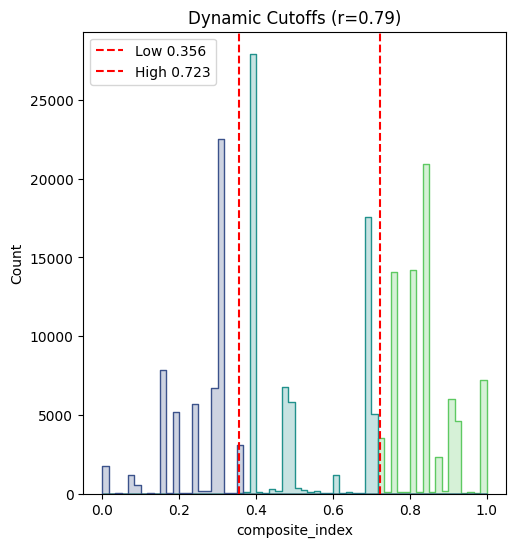

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

# ==========================================
# 1. SETUP & LOAD
# ==========================================
np.random.seed(42)
try:
    drive.mount('/content/drive')
except Exception:
    pass

ORIGINAL_FILE_PATH = '/content/drive/MyDrive/THESIS 47/Saved Datasets/[Non English reviews deleted] All_Language_Data.csv'

print("Loading data...")
try:
    df = pd.read_csv(ORIGINAL_FILE_PATH)
    df = df.dropna(subset=['originalScore', 'sentiment_label'])
    print(f"✅ Loaded {len(df)} rows.")
except Exception as e:
    raise SystemExit(f"Error: {e}")

# ==========================================
# 2. DATA-DRIVEN WEIGHTS (Dynamic)
# ==========================================
print("\n--- 1. CALCULATING DYNAMIC WEIGHTS ---")

# Normalize score
df['norm_score'] = df['originalScore'] / 10.0

# Calculate Correlation
correlation = df['norm_score'].corr(df['sentiment_label'])
print(f"Statistical Correlation (r): {correlation:.4f}")

# Set Weights based on Correlation
W_SCORE = correlation
W_LABEL = 1 - correlation

print(f"Auto-Calculated Weights -> Score: {W_SCORE:.3f} | Label: {W_LABEL:.3f}")

# Apply Formula
df['composite_index'] = (df['norm_score'] * W_SCORE) + (df['sentiment_label'] * W_LABEL)

# ==========================================
# 3. DYNAMIC CUTOFF CALCULATION
# ==========================================
print("\n--- 2. CALCULATING DYNAMIC CUTOFFS ---")
print("Goal: Neutral must include Score 5 (Neg) up to Score 6 (Pos).")

# We simulate the 'Anchors' based on the calculated weights
# 1. Find the edge of Negative Class (Score 4, Label 0)
idx_score_4_neg = (0.4 * W_SCORE) + (0 * W_LABEL)

# 2. Find the start of Neutral Class (Score 5, Label 0)
idx_score_5_neg = (0.5 * W_SCORE) + (0 * W_LABEL)

# 3. Find the end of Neutral Class (Score 6, Label 1)
idx_score_6_pos = (0.6 * W_SCORE) + (1 * W_LABEL)

# 4. Find the start of Positive Class (Score 7, Label 1)
idx_score_7_pos = (0.7 * W_SCORE) + (1 * W_LABEL)

print(f"Reference Anchors:")
print(f"   Score 4 (Neg) Index: {idx_score_4_neg:.3f}")
print(f"   Score 5 (Neg) Index: {idx_score_5_neg:.3f}")
print(f"   Score 6 (Pos) Index: {idx_score_6_pos:.3f}")
print(f"   Score 7 (Pos) Index: {idx_score_7_pos:.3f}")

# CALCULATE CUTOFFS (Midpoints)
# Lower Cutoff: Between Score 4(Neg) and Score 5(Neg)
CUTOFF_LOW = (idx_score_4_neg + idx_score_5_neg) / 2

# Upper Cutoff: Between Score 6(Pos) and Score 7(Pos)
# This ensures Score 6 stays in Neutral, and Score 7 goes to Positive
CUTOFF_HIGH = (idx_score_6_pos + idx_score_7_pos) / 2

# Round for cleanliness
CUTOFF_LOW = round(CUTOFF_LOW, 3)
CUTOFF_HIGH = round(CUTOFF_HIGH, 3)

print(f"\n>>> CALCULATED CUTOFFS: {CUTOFF_LOW} and {CUTOFF_HIGH}")

# ==========================================
# 4. APPLY & ANALYZE
# ==========================================
strategic_bins = [-0.1, CUTOFF_LOW, CUTOFF_HIGH, 1.1]
class_labels = [0, 1, 2]

df['target_label'] = pd.cut(df['composite_index'], bins=strategic_bins, labels=class_labels)

print("\n" + "="*60)
print("COMPOSITION CHECK (Did we capture Score 6?)")
print("="*60)

# Create Cross-Tabulation
composition_table = pd.crosstab(df['target_label'], df['sentiment_label'])
composition_table.columns = ['Original Neg (0)', 'Original Pos (1)']
composition_table.index = ['Negative Class', 'Neutral Class', 'Positive Class']

print(composition_table)
print("-" * 60)

# Check Neutral Balance Potentials
neu_neg = composition_table.loc['Neutral Class', 'Original Neg (0)']
neu_pos = composition_table.loc['Neutral Class', 'Original Pos (1)']
bottleneck = min(neu_neg, neu_pos)

print(f"Neutral Balance Potential:")
print(f"   - Negatives Available: {neu_neg}")
print(f"   - Positives Available: {neu_pos}")
print(f"   - Max Balanced Neutral Size: {bottleneck * 2} ({bottleneck} each)")

# ==========================================
# 5. VISUALIZATION
# ==========================================
plt.figure(figsize=(12, 6))

# Subplot 1: Composite Index with Calculated Lines
plt.subplot(1, 2, 1)
sns.histplot(x=df['composite_index'], hue=df['target_label'], bins=60, palette='viridis', element='step')
plt.axvline(x=CUTOFF_LOW, color='red', linestyle='--', label=f'Low {CUTOFF_LOW}')
plt.axvline(x=CUTOFF_HIGH, color='red', linestyle='--', label=f'High {CUTOFF_HIGH}')
plt.title(f'Dynamic Cutoffs (r={correlation:.2f})')
plt.legend()



In [13]:
# ==========================================
# PART 2: BALANCING & SAVING (Weighted Method)
# ==========================================
# Logic:
# Negative: Pure Negatives (Target 55k)
# Positive: Pure Positives (Target 55k)
# Neutral:  All Positives available (~24k) + fill rest with Negatives -> Target 50k

print("\nStarting Custom Balancing Strategy (Weighted/Correlation Method)...")
SAVE_PATH = '/content/drive/MyDrive/THESIS 47/Saved Datasets/corelation_composite160k.csv'

# --- 1. PURITY FILTERING ---
print("--- 1. APPLYING PURITY FILTERS ---")
# Filter Negative Class (Target 0) -> Must be Sentiment 0
clean_neg_pool = df[(df['target_label'] == 0) & (df['sentiment_label'] == 0)]

# Filter Positive Class (Target 2) -> Must be Sentiment 1
clean_pos_pool = df[(df['target_label'] == 2) & (df['sentiment_label'] == 1)]

# Neutral Pool (Target 1) -> Can be mixed
neutral_pool = df[df['target_label'] == 1]

print(f"   > Clean Negative Pool: {len(clean_neg_pool)}")
print(f"   > Clean Positive Pool: {len(clean_pos_pool)}")

# --- 2. SAMPLING LOGIC ---
print("\n--- 2. EXECUTING SAMPLING ---")

# A. NEUTRAL STRATEGY (Target 50k: All Pos, Rest Neg)
TARGET_NEUTRAL = 50000

# 1. Get ALL Neutral Positives
neu_pos_subset = neutral_pool[neutral_pool['sentiment_label'] == 1]
count_neu_pos = len(neu_pos_subset)

# 2. Calculate Remainder needed from Negatives
needed_neg = TARGET_NEUTRAL - count_neu_pos

print(f"   > Neutral Logic: Taking ALL {count_neu_pos} Positives + {needed_neg} Negatives")

# 3. Get Neutral Negatives
neu_neg_subset = neutral_pool[neutral_pool['sentiment_label'] == 0].sample(n=needed_neg, random_state=42)

# 4. Combine Neutral
df_final_neu = pd.concat([neu_pos_subset, neu_neg_subset])

# B. NEGATIVE & POSITIVE STRATEGY (Target 55k)
TARGET_SIDES = 55000

# Sample Negative
n_neg = min(len(clean_neg_pool), TARGET_SIDES)
df_final_neg = clean_neg_pool.sample(n=n_neg, random_state=42)

# Sample Positive
n_pos = min(len(clean_pos_pool), TARGET_SIDES)
df_final_pos = clean_pos_pool.sample(n=n_pos, random_state=42)

print(f"   > Final Negative Size: {len(df_final_neg)}")
print(f"   > Final Positive Size: {len(df_final_pos)}")

# --- 3. SAVE WITH ALL COLUMNS ---
# Combine all
df_golden = pd.concat([df_final_neg, df_final_neu, df_final_pos])
df_golden = df_golden.sample(frac=1, random_state=42).reset_index(drop=True)

# CRITICAL UPDATE: Include ALL Metadata Columns
cols_to_keep = [
    'title',                # Metadata
    'reviewText',           # Feature
    'originalScore',        # Feature
    'audienceScore',        # Feature
    'tomatoMeter',          # Feature
    'runtimeMinutes',       # Metadata
    'genre',                # Metadata
    'sentiment_label',      # Original Label
    'language_encoded',     # Metadata
    'director_encoded',     # Metadata
    'target_label'          # The New Target
]

# Safety check to ensure columns exist
valid_cols = [c for c in cols_to_keep if c in df_golden.columns]

df_save = df_golden[valid_cols]

df_save.to_csv(SAVE_PATH, index=False)
print(f"\n✅ Part 2 Complete. Saved {len(df_save)} rows to:")
print(SAVE_PATH)
print("Columns included:", df_save.columns.tolist())


Starting Custom Balancing Strategy (Weighted/Correlation Method)...
--- 1. APPLYING PURITY FILTERS ---
   > Clean Negative Pool: 55029
   > Clean Positive Pool: 73674

--- 2. EXECUTING SAMPLING ---
   > Neutral Logic: Taking ALL 24088 Positives + 25912 Negatives
   > Final Negative Size: 55000
   > Final Positive Size: 55000

✅ Part 2 Complete. Saved 160000 rows to:
/content/drive/MyDrive/THESIS 47/Saved Datasets/corelation_composite160k.csv
Columns included: ['title', 'reviewText', 'originalScore', 'audienceScore', 'tomatoMeter', 'runtimeMinutes', 'genre', 'sentiment_label', 'language_encoded', 'director_encoded', 'target_label']


Loading saved file...

FINAL INTEGRITY REPORT
                Original Neg (0)  Original Pos (1)
Negative Class             55000                 0
Neutral Class              25912             24088
Positive Class                 0             55000
------------------------------------------------------------
Automated Checks:
✅ PASS: Negative Class contains 0 Positive reviews.
✅ PASS: Positive Class contains 0 Negative reviews.
ℹ️ INFO: Neutral Class Mix -> 25912 Neg / 24088 Pos


/tmp/ipython-input-470940103.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df_eda, x='target_label', palette='viridis')


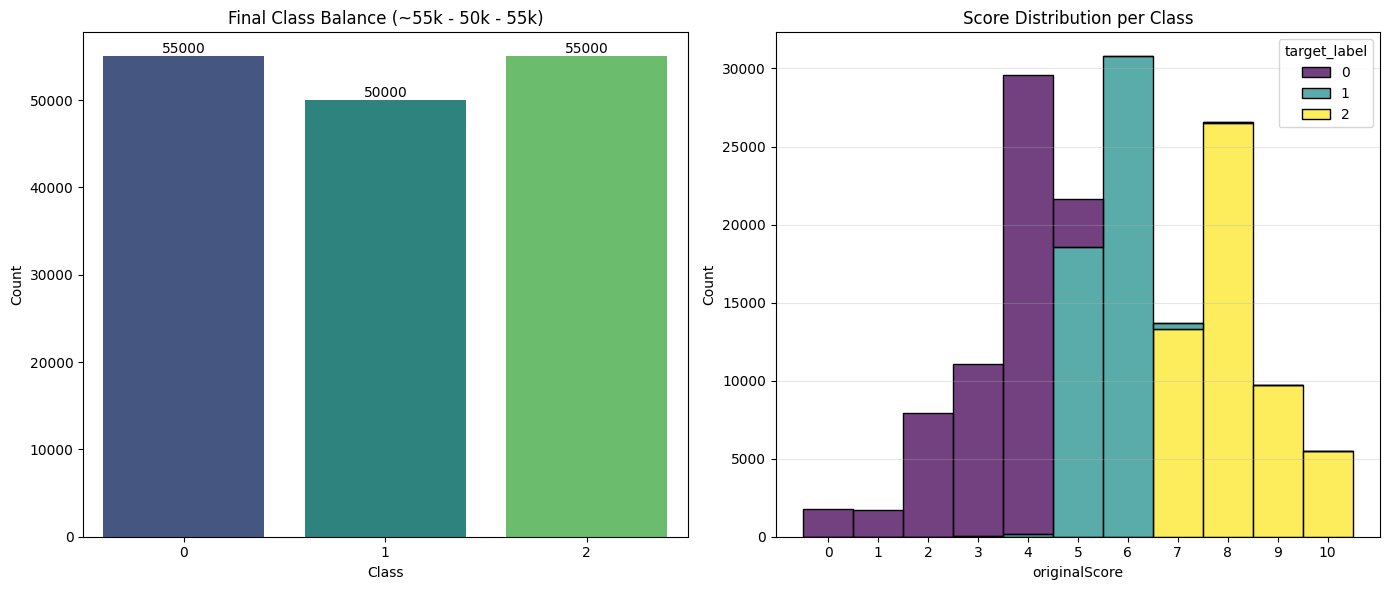

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

SAVE_PATH = '/content/drive/MyDrive/THESIS 47/Saved Datasets/corelation_composite160k.csv'

print("Loading saved file...")
df_eda = pd.read_csv(SAVE_PATH)

# ==========================================
# 1. PURITY & COMPOSITION CHECK
# ==========================================
print("\n" + "="*60)
print("FINAL INTEGRITY REPORT")
print("="*60)

cross_tab = pd.crosstab(df_eda['target_label'], df_eda['sentiment_label'])
cross_tab.columns = ['Original Neg (0)', 'Original Pos (1)']
cross_tab.index = ['Negative Class', 'Neutral Class', 'Positive Class']

print(cross_tab)
print("-" * 60)

# AUTOMATED CHECKS
print("Automated Checks:")
# 1. Check Negative Purity
if cross_tab.loc['Negative Class', 'Original Pos (1)'] == 0:
    print("✅ PASS: Negative Class contains 0 Positive reviews.")
else:
    print("❌ FAIL: Negative Class is contaminated.")

# 2. Check Positive Purity
if cross_tab.loc['Positive Class', 'Original Neg (0)'] == 0:
    print("✅ PASS: Positive Class contains 0 Negative reviews.")
else:
    print("❌ FAIL: Positive Class is contaminated.")

# 3. Check Neutral Composition
neu_pos_count = cross_tab.loc['Neutral Class', 'Original Pos (1)']
neu_neg_count = cross_tab.loc['Neutral Class', 'Original Neg (0)']
print(f"ℹ️ INFO: Neutral Class Mix -> {neu_neg_count} Neg / {neu_pos_count} Pos")


# ==========================================
# 2. VISUALIZATION
# ==========================================
plt.figure(figsize=(14, 6))

# Graph 1: Class Balance
plt.subplot(1, 2, 1)
ax = sns.countplot(data=df_eda, x='target_label', palette='viridis')
plt.title('Final Class Balance (~55k - 50k - 55k)')
plt.xlabel('Class')
plt.ylabel('Count')
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom')

# Graph 2: Original Score Stack
# This shows the "Makeup" of the Neutral class clearly
plt.subplot(1, 2, 2)
sns.histplot(data=df_eda, x='originalScore', hue='target_label', multiple='stack', bins=11, palette='viridis', discrete=True)
plt.title('Score Distribution per Class')
plt.xticks(range(11))
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

Loading saved file for visualization...


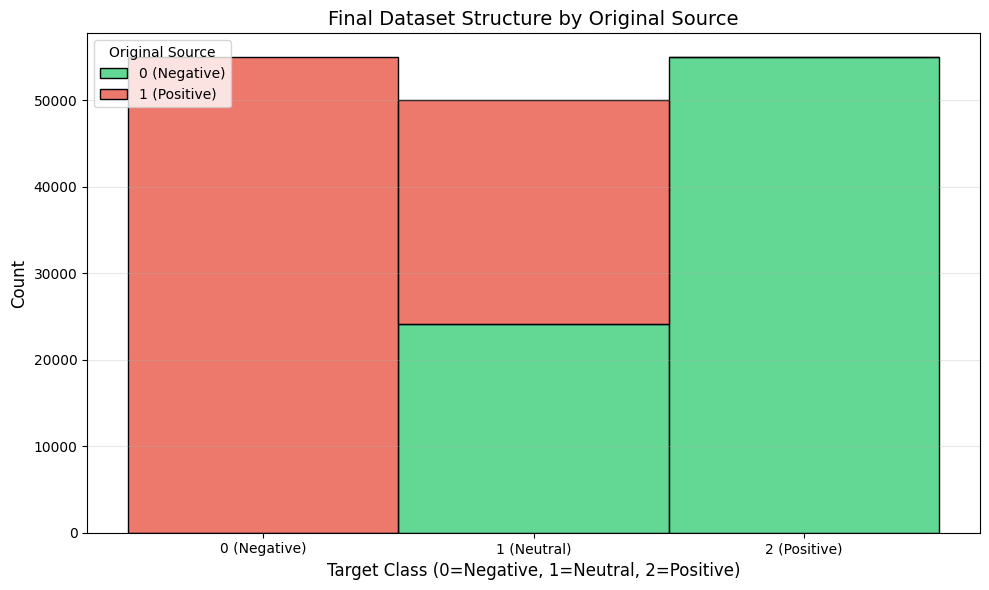


✅ Stacked Composition Graph Generated.


In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

SAVE_PATH = '/content/drive/MyDrive/THESIS 47/Saved Datasets/corelation_composite160k.csv'

print("Loading saved file for visualization...")
df_eda = pd.read_csv(SAVE_PATH)

# ==========================================
# GENERATE STACKED COMPOSITION GRAPH
# ==========================================
plt.figure(figsize=(10, 6))

# Use 'target_label' for x-axis, and 'sentiment_label' for hue (stacking)
sns.histplot(data=df_eda, x='target_label', hue='sentiment_label', multiple='stack',
             bins=[-0.5, 0.5, 1.5, 2.5], # Explicit bins for discrete target_label values
             palette={0: '#e74c3c', 1: '#2ecc71'},
             discrete=True) # Important for integer categories

plt.title('Final Dataset Structure by Original Source', fontsize=14)
plt.xlabel('Target Class (0=Negative, 1=Neutral, 2=Positive)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([0, 1, 2], ['0 (Negative)', '1 (Neutral)', '2 (Positive)']) # Custom x-axis labels
plt.legend(title='Original Source', labels=['0 (Negative)', '1 (Positive)'])
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✅ Stacked Composition Graph Generated.")


PART 2: CLEANING & SAVING FULL DATASET (Method 2 - Weighted)
Applying Strict Purity Filters...
   > Removed 3 contaminated rows from Negative Class.
   > Removed 14 contaminated rows from Positive Class.

✅ SUCCESS! Saved 194784 rows to:
/content/drive/MyDrive/THESIS 47/Saved Datasets/Composite2_194k data.csv

FINAL SANITY CHECK REPORT
1. Class Composition (Check for Purity):
                Orig Neg (0)  Orig Pos (1)
Negative Class         55029             0
Neutral Class          41993         24088
Positive Class             0         73674
------------------------------------------------------------
✅ PASS: Negative Class is 100% Pure.
✅ PASS: Positive Class is 100% Pure.


/tmp/ipython-input-2519606826.py:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df_save, x='target_label', palette='viridis')
/tmp/ipython-input-2519606826.py:106: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Original Source')


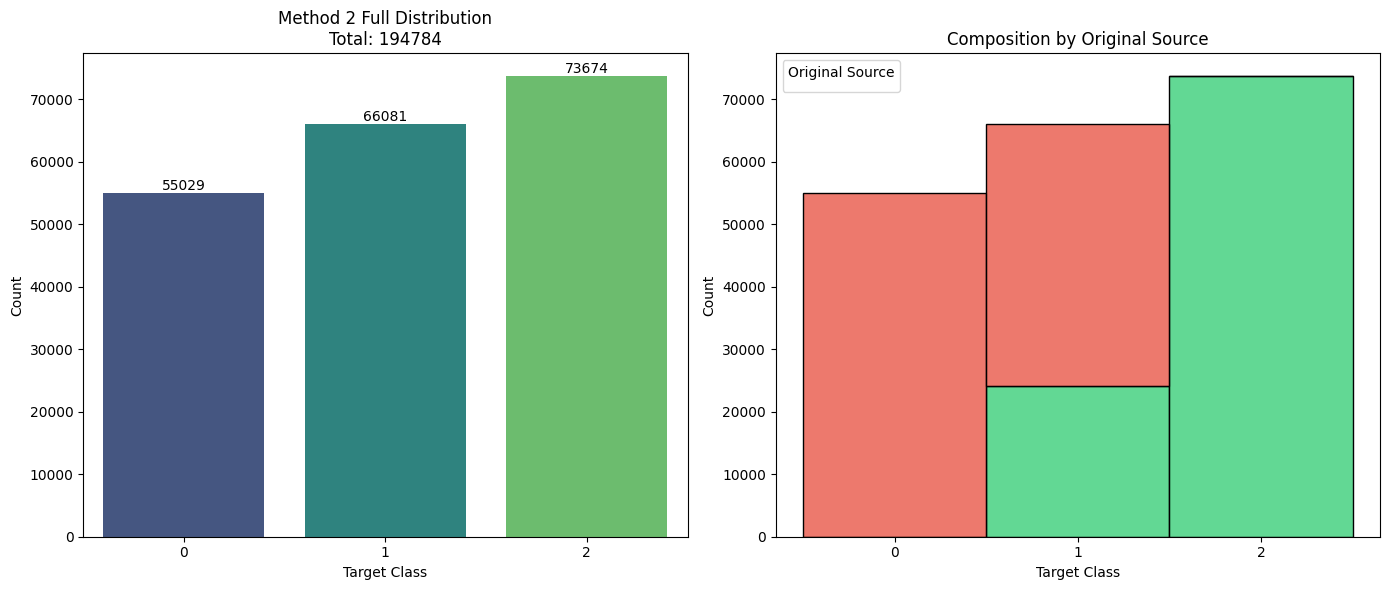

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# PART 2: CLEANING, SAVING FULL DATA & EDA (Weighted Method)
# ==========================================
print("\n" + "="*60)
print("PART 2: CLEANING & SAVING FULL DATASET (Method 2 - Weighted)")
print("="*60)

SAVE_PATH = '/content/drive/MyDrive/THESIS 47/Saved Datasets/Composite2_194k data.csv'

# --- 1. PURITY FILTERING (Removing Contamination) ---
print("Applying Strict Purity Filters...")

# Negative Class (0): Must strictly be Original Negative (0)
df_neg_clean = df[(df['target_label'] == 0) & (df['sentiment_label'] == 0)]

# Positive Class (2): Must strictly be Original Positive (1)
df_pos_clean = df[(df['target_label'] == 2) & (df['sentiment_label'] == 1)]

# Neutral Class (1): Keep EVERYTHING (Mixed is necessary here)
df_neu_clean = df[df['target_label'] == 1]

# Report on cleaning
removed_neg = len(df[df['target_label'] == 0]) - len(df_neg_clean)
removed_pos = len(df[df['target_label'] == 2]) - len(df_pos_clean)
print(f"   > Removed {removed_neg} contaminated rows from Negative Class.")
print(f"   > Removed {removed_pos} contaminated rows from Positive Class.")

# --- 2. COMBINE (NO DOWNSAMPLING) ---
df_full_clean = pd.concat([df_neg_clean, df_neu_clean, df_pos_clean])
df_full_clean = df_full_clean.sample(frac=1, random_state=42).reset_index(drop=True)

# --- 3. SAVE WITH ALL COLUMNS ---
cols_to_keep = [
    'title',                # Metadata
    'reviewText',           # Feature
    'originalScore',        # Feature
    'audienceScore',        # Feature
    'tomatoMeter',          # Feature
    'runtimeMinutes',       # Metadata
    'genre',                # Metadata
    'sentiment_label',      # Original Label
    'language_encoded',     # Metadata
    'director_encoded',     # Metadata
    'target_label'          # The New Class
]

# Safety check to ensure columns exist
valid_cols = [c for c in cols_to_keep if c in df_full_clean.columns]
df_save = df_full_clean[valid_cols]

df_save.to_csv(SAVE_PATH, index=False)
print(f"\n✅ SUCCESS! Saved {len(df_save)} rows to:")
print(SAVE_PATH)

# ==========================================
# PART 3: SANITY CHECK & EDA
# ==========================================
print("\n" + "="*60)
print("FINAL SANITY CHECK REPORT")
print("="*60)

# A. Composition Matrix
print("1. Class Composition (Check for Purity):")
cross_tab = pd.crosstab(df_save['target_label'], df_save['sentiment_label'])
cross_tab.columns = ['Orig Neg (0)', 'Orig Pos (1)']
cross_tab.index = ['Negative Class', 'Neutral Class', 'Positive Class']
print(cross_tab)
print("-" * 60)

# B. Automated Verification
if cross_tab.loc['Negative Class', 'Orig Pos (1)'] == 0:
    print("✅ PASS: Negative Class is 100% Pure.")
else:
    print("❌ FAIL: Negative Class is still contaminated.")

if cross_tab.loc['Positive Class', 'Orig Neg (0)'] == 0:
    print("✅ PASS: Positive Class is 100% Pure.")
else:
    print("❌ FAIL: Positive Class is still contaminated.")

# C. Visualization
plt.figure(figsize=(14, 6))

# Graph 1: Total Counts
plt.subplot(1, 2, 1)
ax = sns.countplot(data=df_save, x='target_label', palette='viridis')
plt.title(f'Method 2 Full Distribution\nTotal: {len(df_save)}')
plt.xlabel('Target Class')
plt.ylabel('Count')
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom')

# Graph 2: Stacked Source
plt.subplot(1, 2, 2)
sns.histplot(data=df_save, x='target_label', hue='sentiment_label', multiple='stack',
             bins=[-0.5, 0.5, 1.5, 2.5], palette={0: '#e74c3c', 1: '#2ecc71'}, discrete=True)
plt.title('Composition by Original Source')
plt.xlabel('Target Class')
plt.xticks([0, 1, 2])
plt.legend(title='Original Source')

plt.tight_layout()
plt.show()